In [1]:
pip install umap-learn

In [2]:
import pandas as pd
import umap


In [3]:
# Cambia la ruta por la de tu CSV


df_pca = pd.read_csv("X_train_pca_k553.csv")
df_test = pd.read_csv("X_test_pca_k553.csv")

#Si solo quieres los valores numéricos:
X_pca = df_pca.values
X_test = df_test.values
# Inicializamos UMAP para reducir a 2D (para visualización)
reducer = umap.UMAP(n_components=2, random_state=42)

# Ajustamos y transformamos los datos
X_umap_train = reducer.fit_transform(X_pca)
X_umap_test = reducer.fit_transform(X_test)
# X_umap ahora es un array de shape (n_samples, 2)
df_umap_train = pd.DataFrame(X_umap_train, columns=['UMAP1', 'UMAP2'])
df_umap_train.to_csv("X_umap_train.csv", index=False)

df_umap_test = pd.DataFrame(X_umap_test, columns=['UMAP1', 'UMAP2'])
df_umap_test.to_csv("X_umap_test.csv", index=False)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


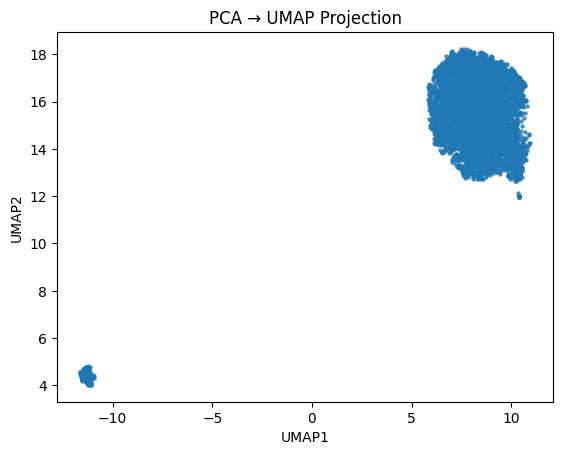

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df_umap_train['UMAP1'], df_umap_train['UMAP2'], s=5, alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("PCA → UMAP Projection")
plt.show()

In [5]:
import numpy as np
import pandas as pd

def kmeans(X, k=5, max_iters=100, tolerance=1e-4, random_state=42, save_path=None):

    np.random.seed(random_state)

    # === Inicialización de centroides ===
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for iteration in range(max_iters):
        # === Asignar cada punto al cluster más cercano ===
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # === Recalcular centroides ===
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # === Verificar convergencia ===
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tolerance:
            print(f" Convergencia alcanzada en iteración {iteration+1}")
            break

        centroids = new_centroids

    else:
        print(f" Se alcanzó el máximo de {max_iters} iteraciones sin converger")
    if save_path:
        pd.DataFrame(labels, columns=["cluster"]).to_csv(save_path, index=False)
        print(f" Etiquetas guardadas en '{save_path}'")

    print(f"\nTotal de iteraciones: {iteration+1}")
    print(f"Clusters encontrados: {len(np.unique(labels))}\n")

    return labels, centroids, iteration + 1

# Cargar tu dataset reducido
X = pd.read_csv("X_umap_train.csv").values

# Ejecutar K-Means
labels, centroids, iters = kmeans(X, k=5, max_iters=100, tolerance=1e-4, save_path="train_clusters_kmeans.csv")



 Convergencia alcanzada en iteración 25
 Etiquetas guardadas en 'train_clusters_kmeans.csv'

Total de iteraciones: 25
Clusters encontrados: 5



In [6]:
# cargar asignaciones de clusters
clusters = pd.read_csv("train_clusters_kmeans.csv")

# conteo de películas por cluster
print("=== Distribución de películas por cluster ===")
print(clusters['cluster'].value_counts().sort_index())

# porcentaje
print("\n=== Porcentaje de cada cluster ===")
print((clusters['cluster'].value_counts(normalize=True) * 100).round(2))


=== Distribución de películas por cluster ===
cluster
0    1151
1     203
2    1378
3    1228
4    1273
Name: count, dtype: int64

=== Porcentaje de cada cluster ===
cluster
2    26.33
4    24.33
3    23.47
0    22.00
1     3.88
Name: proportion, dtype: float64


# Metricas internas

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np

# === Cargar datos reducidos y etiquetas de clusters ===
df_umap = pd.read_csv("X_umap_train.csv")
clusters = pd.read_csv("train_clusters_kmeans.csv")

X = df_umap[["UMAP1", "UMAP2"]].values
labels = clusters["cluster"].values

# === 1️⃣ Métricas de evaluación interna ===
sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)
ch_index = calinski_harabasz_score(X, labels)

print(f" Silhouette Score: {sil_score:.4f}")
print(f" Davies-Bouldin Index: {db_index:.4f}")
print(f" Calinski-Harabasz Index: {ch_index:.2f}")
# === Guardar resultados en CSV ===
metrics_df = pd.DataFrame({
    "Silhouette_Score": [sil_score],
    "Davies_Bouldin_Index": [db_index],
    "Calinski_Harabasz_Index": [ch_index]
})
metrics_df.to_csv("metricas_umap_kmeans.csv", index=False)
print("\n📁 Resultados guardados en 'metricas_umap_kmeans.csv'")


 Silhouette Score: 0.4048
 Davies-Bouldin Index: 0.6756
 Calinski-Harabasz Index: 33101.73

📁 Resultados guardados en 'metricas_umap_kmeans.csv'


#GRAFICAS

### Visualización de los clusters en el espacio UMAP

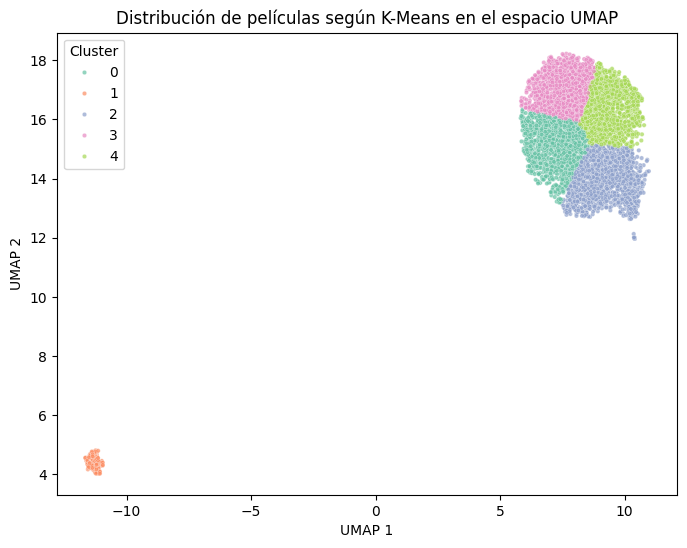

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Cargar los datos y clusters ===
df_umap = pd.read_csv("X_umap_train.csv")
clusters = pd.read_csv("train_clusters_kmeans.csv")

# Unir ambos DataFrames
df_umap["cluster"] = clusters["cluster"]

# === Graficar ===
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_umap,
    x="UMAP1", y="UMAP2",
    hue="cluster",
    palette="Set2",
    s=10, alpha=0.7
)
plt.title("Distribución de películas según K-Means en el espacio UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()


### Distribución de tamaños de los clusters (barras o pastel)

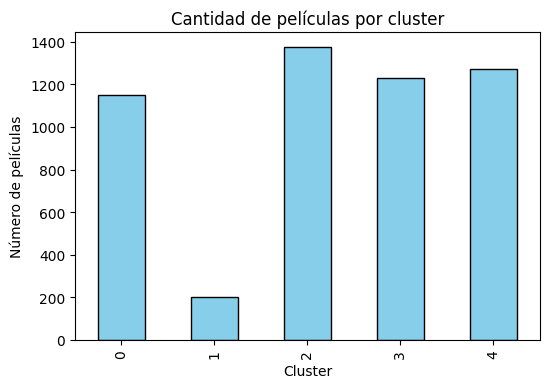

In [9]:
plt.figure(figsize=(6,4))
clusters["cluster"].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Cantidad de películas por cluster")
plt.xlabel("Cluster")
plt.ylabel("Número de películas")
plt.show()


### Gráfico del Silhouette Score por cluster

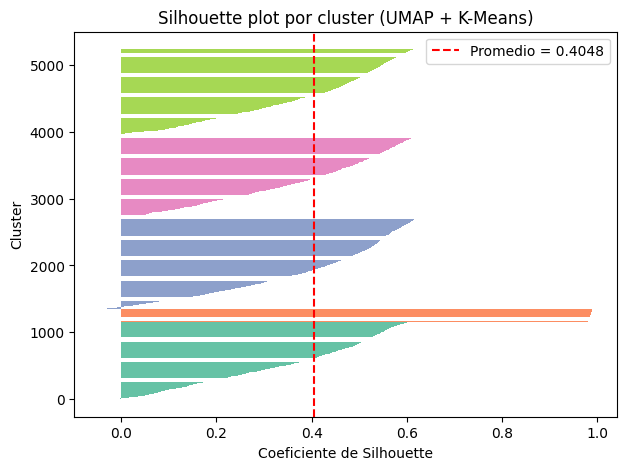

In [11]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar datos y etiquetas
df_umap = pd.read_csv("X_umap_train.csv")
clusters = pd.read_csv("train_clusters_kmeans.csv")
df_umap["cluster"] = clusters["cluster"]

# Calcular valores individuales de silhouette
silhouette_vals = silhouette_samples(df_umap[["UMAP1", "UMAP2"]].values, df_umap["cluster"])

# Promedio global
mean_score = silhouette_vals.mean()

# === Gráfico ===
y_lower, y_upper = 0, 0
yticks = []

plt.figure(figsize=(7,5))
for i, c in enumerate(np.unique(df_umap["cluster"])):
    c_silhouette_vals = silhouette_vals[df_umap["cluster"] == c]
    c_silhouette_vals.sort()
    y_upper += len(c_silhouette_vals)
    color = plt.cm.Set2(i)
    plt.barh(range(y_lower, y_upper), c_silhouette_vals, edgecolor='none', color=color)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(c_silhouette_vals)

plt.axvline(mean_score, color="red", linestyle="--", label=f"Promedio = {mean_score:.4f}")
plt.title("Silhouette plot por cluster (UMAP + K-Means)")
plt.xlabel("Coeficiente de Silhouette")
plt.ylabel("Cluster")
plt.legend()
plt.show()


### Diagrama de Voronoi (fronteras entre clusters)

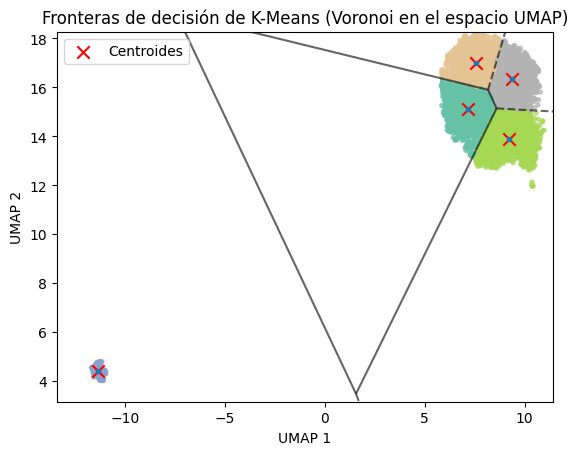

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

# Cargar datos
df_umap = pd.read_csv("X_umap_train.csv")
clusters = pd.read_csv("train_clusters_kmeans.csv")
df_umap["cluster"] = clusters["cluster"]

# Calcular centroides en el espacio UMAP
centroids = df_umap.groupby("cluster")[["UMAP1", "UMAP2"]].mean().values

# Graficar Voronoi
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6)

# Puntos coloreados por cluster
plt.scatter(df_umap["UMAP1"], df_umap["UMAP2"], c=df_umap["cluster"], cmap="Set2", s=8, alpha=0.7)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=80, marker='x', label="Centroides")
plt.title("Fronteras de decisión de K-Means (Voronoi en el espacio UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


### Heatmap de proximidad entre centroides

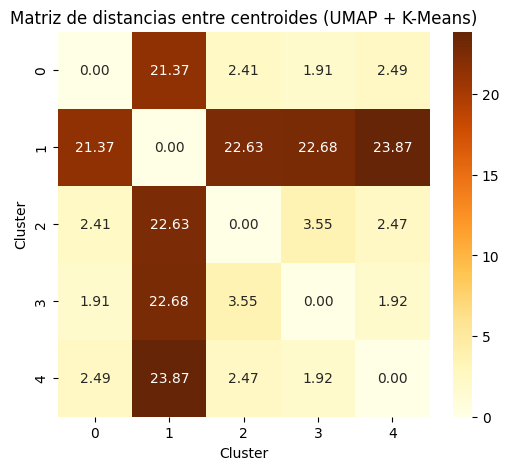

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Calcular distancias entre centroides
from scipy.spatial.distance import cdist

centroids = df_umap.groupby("cluster")[["UMAP1", "UMAP2"]].mean()
dist_matrix = cdist(centroids, centroids)

plt.figure(figsize=(6,5))
sns.heatmap(dist_matrix, annot=True, cmap="YlOrBr", fmt=".2f")
plt.title("Matriz de distancias entre centroides (UMAP + K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()
